In [1]:
import torch.nn    as nn
import torch.optim as optim
import numpy       as np
import torch
import json
import os

from libraries.model      import nGCNN, eGCNN, diffusion_step, add_features_to_graph, get_graph_losses
from libraries.dataset    import standardize_dataset
from libraries.graph      import graph_POSCAR_encoding
from torch.utils.data     import random_split
from torch_geometric.data import Data

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Based on adding and removing noise to materials
# the models is able to learn hidded patterns
# It can be trained regarding some target property

In [3]:
# In case database is created from scratch (otherwise, it is not being used)
DB_path = '../MP/Loaded_PT'

# Define folder in which all data will be stored
target_folder    = 'models/GM_BiSI'
edge_model_name = f'{target_folder}/edge_model.pt'
node_model_name = f'{target_folder}/node_model.pt'

In [4]:
# Define target value to look for
#seeked_target = ##

# Machine-learning parameters
n_epochs      = 3000
batch_size    = 32
learning_rate = 0.0001

# Ratios for dividing training data
test_ratio = 0.0

# Number of diffusing and denoising steps
n_t_steps = 100

# Decay of parameter alpha
noise_contribution = 0.05
alpha_decay = 0.5 * (1 - noise_contribution**2)

# Dropouts for node and edge models (independent of each other)
dropout_node = 0.2
dropout_edge = 0.2

# Create and save as a dictionary
model_parameters = {
    'n_epochs':           n_epochs,
    'batch_size':         batch_size,
    'learning_rate':      learning_rate,
    'test_ratio':         test_ratio,
    'n_t_steps':          n_t_steps,
    'noise_contribution': noise_contribution,
    'dropout_node':       dropout_node,
    'dropout_edge':       dropout_edge
}

# Write the dictionary to the file in JSON format
with open(f'{target_folder}/model_parameters.json', 'w') as json_file:
    json.dump(model_parameters, json_file)

# Generation of graph database for training

Load the datasets, already standardized if possible.

labels_name                 = f'{target_folder}/labels.pt'
dataset_name                = f'{target_folder}/dataset.pt'
dataset_name_std            = f'{target_folder}/standardized_dataset.pt'
dataset_parameters_name_std = f'{target_folder}/standardized_dataset_parameters.json'

if os.path.exists(dataset_name_std) and os.path.exists(dataset_parameters_name_std) and os.path.exists(labels_name):
    # Load the standardized dataset, with corresponding labels and parameters
    dataset = torch.load(dataset_name_std)
    labels  = torch.load(labels_name)
    
    # Load the data from the JSON file
    with open(dataset_parameters_name_std, 'r') as json_file:
        numpy_dict = json.load(json_file)

    # Convert NumPy arrays back to PyTorch tensors
    dataset_parameters = {key: torch.tensor(value) for key, value in numpy_dict.items()}

elif os.path.exists(dataset_name) and os.path.exists(labels_name):
    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(dataset_name)
    labels  = torch.load(labels_name)
    
    # Standardize dataset
    dataset, dataset_parameters = standardize_dataset(dataset)
    
    # Save standardized dataset
    torch.save(dataset, dataset_name_std)
    
    # Convert torch tensors to numpy arrays
    numpy_dict = {key: value.cpu().numpy().tolist() for key, value in dataset_parameters.items()}

    # Dump the dictionary with numpy arrays to a JSON file
    with open(parameters_name_std, 'w') as json_file:
        json.dump(numpy_dict, json_file)

else:
    # Generate the raw dataset from scratch, and standardize it
    
    # Read all mateials within the database
    materials = os.listdir(DB_path)
    
    dataset = []
    labels  = []
    for material in materials:
        try:
            # Try to read the polyforms
            polymorfs = os.listdir(f'{DB_path}/{material}')
        except:
            continue
        
        print(material)
        for polymorf in polymorfs:
            # Path to folder containing the POSCAR
            path_to_POSCAR = f'{DB_path}/{material}/{polymorf}'
            
            # Check that the folder is valid
            if os.path.exists(f'{path_to_POSCAR}/POSCAR'):
                print(f'\t{polymorf}')

                # Extract parameters from POSCAR
                cell, composition, concentration, positions = MPL.information_from_VASPfile(path_to_POSCAR,
                                                                                            'POSCAR')

                # Generate POSCAR covering the box
                try:
                    nodes, edges, attributes, _, _, _ = graph_POSCAR_encoding(cell,
                                                                                  composition,
                                                                                  concentration,
                                                                                  positions,
                                                                                  L)
                except:
                    print(f'Error: {material} {polymorf} not loaded')
                    continue

                # Load ground state energy per atom
                gs_energy = float(np.loadtxt(f'{path_to_POSCAR}/EPA'))

                # Construct temporal graph structure
                graph = Data(x=nodes,
                             edge_index=edges,
                             edge_attr=attributes,
                             y=torch.tensor([[gs_energy]], dtype=torch.float)
                            )

                # Append to dataset and labels
                dataset.append(graph)
                labels.append(f'{material}-{polymorf}')
    
    # Standardize dataset
    dataset, dataset_parameters = standardize_dataset(dataset)
    
    # Save standardized dataset
    torch.save(dataset, dataset_name_std)
    torch.save(labels,  labels_name)
    
    # Convert torch tensors to numpy arrays
    numpy_dict = {key: value.cpu().numpy().tolist() for key, value in dataset_parameters.items()}

    # Dump the dictionary with numpy arrays to a JSON file
    with open(dataset_parameters_name_std, 'w') as json_file:
        json.dump(numpy_dict, json_file)

In [5]:
labels_name                 = f'{target_folder}/labels.pt'
dataset_name                = f'{target_folder}/dataset.pt'
dataset_name_std            = f'{target_folder}/standardized_dataset.pt'
dataset_parameters_name_std = f'{target_folder}/standardized_dataset_parameters.json'

from pymatgen.io.vasp.inputs  import Poscar
from pymatgen.io.vasp.outputs import Vasprun

import sys
sys.path.append('../../UCL/m3gnet')
import ML_library as MLL

dataset = []
labels  = []

### Loaded database ###

data_path = 'Loaded_BiSI/gamma'

# Iterate over materials and relaxations in the dataset
while len(dataset) < 200:
    for material in os.listdir(data_path):
        # Define path to material
        path_to_material = f'{data_path}/{material}'

        # Check if it is a folder
        if not os.path.isdir(path_to_material):
            continue

        print()
        print(material)

        # Get relaxations steps (rel1, rel2...)
        relaxation_steps = os.listdir(path_to_material)

        # Determine all defect states across every folder
        defect_states = []
        for relaxation_step in relaxation_steps:
            path_to_relaxation_step = f'{path_to_material}/{relaxation_step}'
            if os.path.isdir(path_to_relaxation_step):
                for defect_state in os.listdir(path_to_relaxation_step):
                    if os.path.isdir(f'{path_to_material}/{relaxation_step}/{defect_state}'):
                        defect_states.append(defect_state)

        # Determine unique defect states across every folder
        unique_defect_states = np.unique(defect_states)

        # Run over all defect states
        for defect_state in unique_defect_states:
            print(f'\t{defect_state}')

            # Run over all relaxation steps
            for relaxation_step in relaxation_steps:
                # Define path to relaxation loading every relaxation step of a same defect state in the same data column
                path_to_deformation = f'{path_to_material}/{relaxation_step}/{defect_state}'

                # Avoiding non-directories (such as .DS_Store)
                if not os.path.isdir(path_to_deformation):
                    continue

                # Define name for the defect state folder
                temp_relaxation = f'{material}_{defect_state}'

                # Check if it is a valid relaxation (with a vasprun.xml file)
                # If not, it might be that there are different deformation folders of the defect state
                if MLL.is_relaxation_folder_valid(path_to_deformation):
                    path_to_relaxations = [path_to_deformation]
                else:
                    # Try to extact deformation folders
                    deformation_folders = os.listdir(path_to_deformation)

                    # Run over deformations
                    path_to_relaxations = []
                    for deformation_folder in deformation_folders:
                        path_to_relaxation = f'{path_to_deformation}/{deformation_folder}'
                        if MLL.is_relaxation_folder_valid(path_to_relaxation):
                            path_to_relaxations.append(path_to_relaxation)

                # Gather relaxations from different deformations as different ionic steps
                for path_to_relaxation in path_to_relaxations:
                    # Remove invalid characters from the vasprun.xml file
                    MLL.clean_vasprun(path_to_relaxation)  # Uncomment is it happens to you as well!!

                    if not os.path.exists(f'{path_to_relaxation}/vasprun.xml'):
                        print(f'Check {path_to_relaxation}')

                    # Load data from relaxation
                    try:
                        # Try to load those unfinished relaxations as well
                        vasprun = Vasprun(f'{path_to_relaxation}/vasprun.xml', exception_on_bad_xml=False)
                    except:
                        print('Error: vasprun not correctly loaded.')
                        continue

                    # Run over ionic steps
                    for ionic_step_idx in range(len(vasprun.ionic_steps)):
                        temp_ionic_step = f'{temp_relaxation}_{ionic_step_idx}'
                        # Extract data from each ionic step
                        temp_structure = vasprun.ionic_steps[ionic_step_idx]['structure']
                        temp_energy    = vasprun.ionic_steps[ionic_step_idx]['e_fr_energy']

                        # Save temp_structure to POSCAR
                        #temp_Poscar = Poscar(temp_structure)
                        #temp_Poscar.write_file('POSCAR')
                        
                        nodes, edges, attributes = graph_POSCAR_encoding(temp_structure)

                        # Construct temporal graph structure
                        graph = Data(x=nodes,
                                     edge_index=edges,
                                     edge_attr=attributes,
                                     y=torch.tensor([[temp_energy]], dtype=torch.float)
                                    )

                        # Append to dataset and labels
                        dataset.append(graph)
                        labels.append(f'')


BiSBr

BiSeBr

BiSeI

BiSI
	as_1_Bi_on_S_-1
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_-2
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_0
	as_1_Bi_on_S_1
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_2
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_3
Error: vasprun not correctly loaded.
	as_1_Bi_on_S_4
	as_1_Bi_on_S_5
	as_1_I_on_Bi_-1
Error: vasprun not correctly loaded.
Error: vasprun not correctly loaded.
Error: vasp

KeyboardInterrupt: 

In [6]:
# Standardize dataset
dataset, dataset_parameters = standardize_dataset(dataset)

# Save standardized dataset
torch.save(dataset, dataset_name_std)
torch.save(labels,  labels_name)

# Convert torch tensors to numpy arrays
numpy_dict = {key: value.cpu().numpy().tolist() for key, value in dataset_parameters.items()}

# Dump the dictionary with numpy arrays to a JSON file
with open(dataset_parameters_name_std, 'w') as json_file:
    json.dump(numpy_dict, json_file)

# Definition of train-test datasets

In [7]:
# torch.manual_seed(12345)

# Define the sizes of the train and test sets
test_size  = int(test_ratio * len(dataset))
train_size = len(dataset) - test_size

# Use random_split() to generate train and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of testing  graphs: {len(test_dataset)}')

Number of training graphs: 28569
Number of testing  graphs: 0


# Training of the model

In [8]:
# Determine number of features in dataset, considering the t_step information
n_features = dataset[0].num_node_features + 1

# Instantiate the models for nodes and edges
node_model = nGCNN(n_features, dropout_node).to(device)
edge_model = eGCNN(n_features, dropout_edge).to(device)

# Load previous model if available
try:
    node_model.load_state_dict(torch.load(node_model_name))
    edge_model.load_state_dict(torch.load(edge_model_name))
except FileNotFoundError:
    pass

# Evaluate model state
node_model.eval()
edge_model.eval()

print('\nNode GCNN:')
print(node_model)
print('\nEdge GCNN:')
print(edge_model)


Node GCNN:
nGCNN(
  (conv1): GraphConv(5, 256)
  (conv2): GraphConv(256, 5)
)

Edge GCNN:
eGCNN(
  (linear1): Linear(in_features=6, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# Loss factor for normalization
loss_factor = len(train_dataset) * n_t_steps

# Initialize the optimizers
node_optimizer = torch.optim.Adam(node_model.parameters(), lr=learning_rate)
edge_optimizer = torch.optim.Adam(edge_model.parameters(), lr=learning_rate)

# Training loop
total_losses = []
edge_losses  = []
node_losses  = []
for epoch in range(n_epochs):
    # Initialize train loss variable
    total_loss_cum = 0
    edge_loss_cum  = 0
    node_loss_cum  = 0
    for graph in train_dataset:
        #print()
        # Clone existing graph
        graph_0 = graph.clone()
        
        # Initialize the gradient of the optimizers
        node_optimizer.zero_grad()
        edge_optimizer.zero_grad()
        
        # Start denoising-diffusing process
        for t_step in np.arange(1, n_t_steps+1):
            # Diffuse the graph with some noise
            #print()
            #print(f'Step: {t_step}')
            #print('Diffusing...')
            
            graph_t, epsilon_t = diffusion_step(graph_0, t_step, n_t_steps, alpha_decay)
            
            # Update diffused graph as next one
            graph_0 = graph_t.clone()

            # Denoise the diffused graph
            #print(f'Denoising...')
            
            # Add t_step information to graph_t
            t_step_std = (t_step/n_t_steps - 0.5)  # Standard normalization
            graph_t = add_features_to_graph(graph_t,
                                            torch.tensor([[t_step_std]], dtype=torch.float))  # To match graph.y shape
            
            # Add target information
            #graph_t = add_features_to_graph(graph_t,
            #                                    graph_t.y)

            # Perform a single forward pass for predicting node features
            out_x = node_model(graph_t.x,
                               graph_t.edge_index,
                               graph_t.edge_attr)
            
            # Remove t_step information
            out_x = out_x[:, :-1]

            # Define x_i and x_j as features of every corresponding pair of nodes (same order than attributes)
            x_i = graph_t.x[graph_t.edge_index[0]]
            x_j = graph_t.x[graph_t.edge_index[1]]

            # Perform a single forward pass for predicting edge attributes
            # Introduce previous edge attributes as features as well
            out_attr = edge_model(x_i, x_j, graph_t.edge_attr)

            # Construct noise graph
            pred_epsilon_t = Data(x=out_x,
                                  edge_index=graph_t.edge_index,
                                  edge_attr=out_attr.ravel())
            
            # Backpropagation and optimization step
            #print('Backpropagating...')

            # Calculate the loss for node features and edge attributes
            node_loss, edge_loss = get_graph_losses(epsilon_t, pred_epsilon_t)
            
            # Backpropagate and optimize node loss
            node_loss.backward(retain_graph=True)
            node_optimizer.step()

            # Backpropagate and optimize edge loss
            edge_loss.backward(retain_graph=True)
            edge_optimizer.step()

            # Accumulate the total training loss
            loss = node_loss + edge_loss
            
            # Get items
            total_loss_cum += loss.item()
            edge_loss_cum  += edge_loss.item()
            node_loss_cum  += node_loss.item()
    
    # Compute the average train loss
    total_loss_cum = total_loss_cum / loss_factor
    edge_loss_cum  = edge_loss_cum  / loss_factor
    node_loss_cum  = node_loss_cum  / loss_factor
    
    # Append average losses
    total_losses.append(total_loss_cum)
    edge_losses.append(edge_loss_cum)
    node_losses.append(node_loss_cum)
    
    print(f'Epoch: {epoch+1}, total loss: {total_loss_cum:.4f}, edge loss: {edge_loss_cum:.4f}, node loss: {node_loss_cum:.4f}')
    
    # Save some checkpoints
    if (epoch % 20) == 0:
        torch.save(node_model.state_dict(), node_model_name)
        torch.save(edge_model.state_dict(), edge_model_name)

torch.save(node_model.state_dict(), node_model_name)
torch.save(edge_model.state_dict(), edge_model_name)

Epoch: 1, total loss: 5162.7179, edge loss: 1.7447, node loss: 5160.9732
Epoch: 2, total loss: 40.5703, edge loss: 1.0000, node loss: 39.5702
Epoch: 3, total loss: 15.8177, edge loss: 1.0000, node loss: 14.8177
Epoch: 4, total loss: 4.7041, edge loss: 1.0000, node loss: 3.7041



KeyboardInterrupt



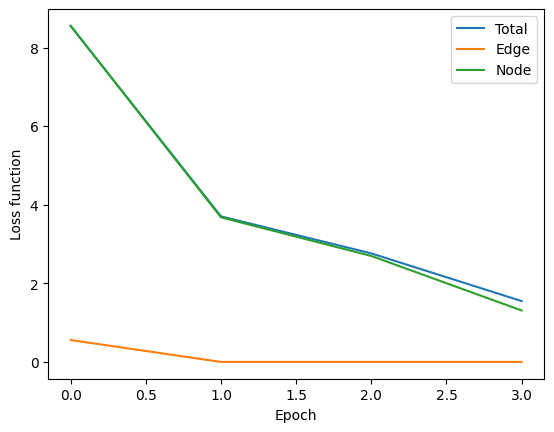

In [10]:
import matplotlib.pyplot as plt
plt.plot(np.log(total_losses), label='Total')
plt.plot(np.log(edge_losses),  label='Edge')
plt.plot(np.log(node_losses),  label='Node')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='best')
plt.show()